# Assignment1. KNN으로 hyperparmeter tuning 이해하기

1. Preprocessing EDA
2. GridSearchCV
3. Evaluation

---

## 1. Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# iris data 불러오기
from sklearn.datasets import load_iris

In [2]:
# 데이터를 다루기 쉽도록 DataFrame으로 만들어주기
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

iris_feature = iris_df.drop('target', axis=1) # feature
iris_target = iris_df['target'] # target

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# train, test data로 분리 (test size = 0.3으로 설정)
X_train, X_test, y_train, y_test = \
    train_test_split(iris_feature, iris_target, test_size=0.3, stratify=iris_target)

In [4]:
# stratify=iris_target 사용하였기 때문에 train 데이터와 test 데이터에서의 label의 분포가 동일
# (이 경우에는 target이 매우 balance하지만, imbalance한 데이터셋의 경우 해주는 것이 좋다고 한다.)
print(y_train.value_counts())
print('-'*50)
print(y_test.value_counts())

2    35
1    35
0    35
Name: target, dtype: int64
--------------------------------------------------
2    15
1    15
0    15
Name: target, dtype: int64


In [5]:
# KNN은 거리기반 알고리즘이기 때문에 scaling을 진행
# 근데 이 데이터셋의 경우 단위가 모두 cm로 동일하기 때문에 굳이 scaling을 해주어야 하나 의문이긴 하다.
# 우선 시도해보도록 하자.

# MinMaxScaling은 (x-min)/(max-min)으로 scaling (값의 범위를 0과 1 사이로 정규화)
# StandardScaling은 (x-mean)/std 으로 scaling (평균 0, 표준편차 1로 표준화)
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# X_train 데이터로만 fit하고, test 데이터는 transform만 한다.
minmax_scaler.fit(X_train)
X_mm_train = minmax_scaler.transform(X_train)
X_mm_test  = minmax_scaler.transform(X_test)

standard_scaler.fit(X_train)
X_ss_train = standard_scaler.transform(X_train)
X_ss_test  = standard_scaler.transform(X_test)

In [6]:
# 다차원의 경우 시각화가 어렵기 때문에 우선 두 개의 feature를 뽑아 시각화해보도록 한다.
def get_scatterplot(feature_col, data):
    nrow = round( (len(feature_col)) * (len(feature_col)-1) / 4 )
    fig, axes = plt.subplots(nrows=nrow, ncols=2, figsize=(12, 4*nrow))
    index = 0
    for i in range(len(feature_col)):
        for j in range(i+1, len(feature_col)):
            row = index // 2
            col = index % 2
            sns.scatterplot(x=feature_col[i], y=feature_col[j], hue='target', data=iris_df, palette='Set2', ax=axes[row][col])
            index += 1

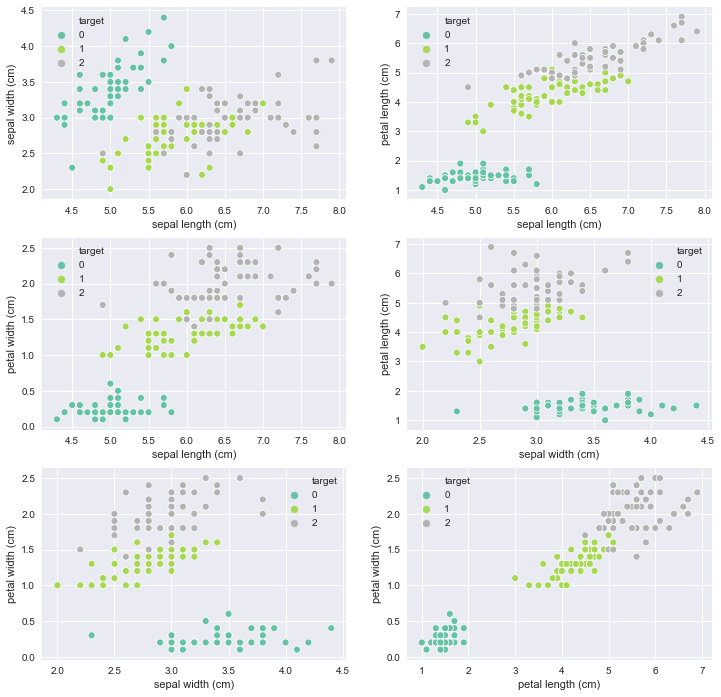

In [7]:
feature_col = iris_df.columns.tolist()[:-1]
get_scatterplot(feature_col, X_train)

# x축이 speal length, y축이 sepal width인 경우 1, 2가 섞여있는 구간이 존재한다.
# 하지만 그 외의 경우에는 scatter plot만 보아도 어느 정도 구분되어 보인다.

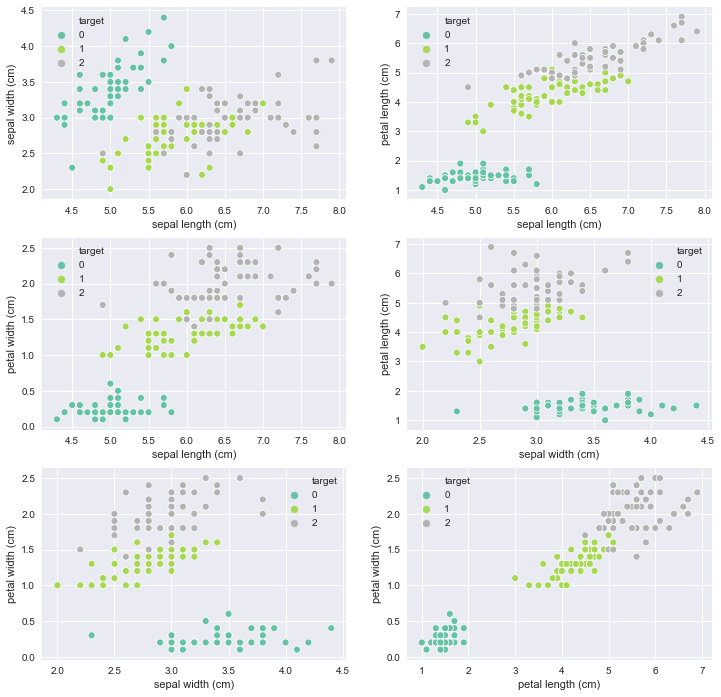

In [8]:
get_scatterplot(feature_col, X_mm_train)

# minmax scaling한 데이터로도 scatter plot을 그려보았다.
# 역시 x축이 speal length, y축이 sepal width인 경우를 제외하고는 대부분 잘 분류될 것으로 예상된다.

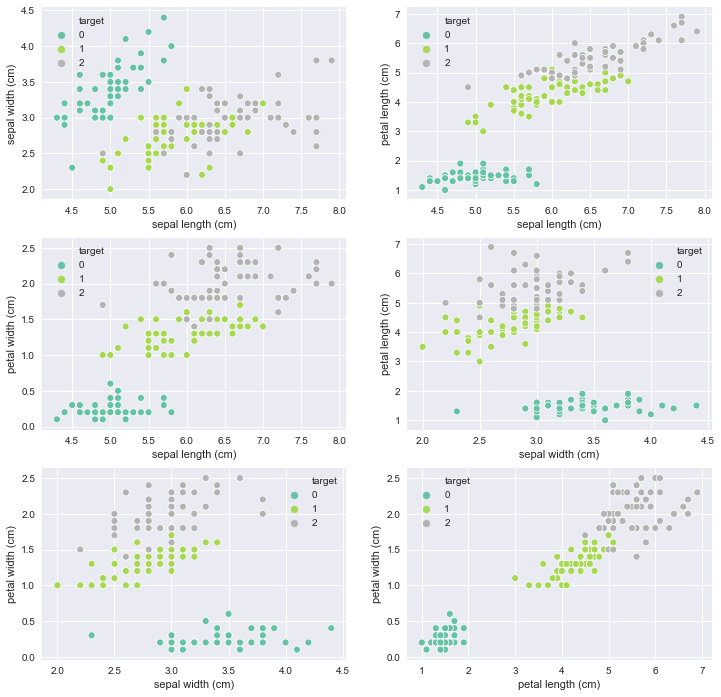

In [9]:
get_scatterplot(feature_col, X_ss_train)

## 2. GridSearch

KNeighborsClassifier(  
    n_neighbors=5,  
    weights='uniform',  
    algorithm='auto',  
    leaf_size=30,  
    p=2,  
    metric='minkowski',  
    metric_params=None,  
    n_jobs=None,  
    **kwargs,  
)  

In [10]:
# KNN은 가장 가까운 k개의 데이터를 보고, 그 데이터의 label을 이용해 predict하는 방식

# n_neighbors는 k를 의미 (몇 개의 가까운 데이터를 볼 것인지)
# k가 클수록 지역적 특색 덜 반영 (=정규화 심하게 = underfitting)
# k가 작을수록 지역적 특색 많이 반영 (=overfitting)
# 적절한 k를 찾는 것이 중요

# weights는 uniform과 distance가 있는데, 
# uniform의 경우 우리의 데이터에서 얼마만큼 떨어져 있는 target을 예측하는 데 동일한 weight를 부여하겠다는 의미
# distance의 경우 거리가 가까울수록 target을 예측하는데 weight를 더 부여하겠다는 의미

params = {
    'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17],
    'weights':['uniform', 'distance'],
}

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier() # KNN 객체
grid_cv = GridSearchCV(knn, params, cv=5, scoring='accuracy') # gridsearch할 파라미터 넣어주고, cv=5로, scoring은 accuracy로 하도록 한다.

# cv = 5
# data를 5등분하여 4조각은 train하는 데 사용하고, 1개의 데이터는 test하는 데 사용하겠다는 의미
# 이 test하는 데이터를 번갈아 가면서 train을 총 5번 진행한다. 따라서 test score도 5개가 나온다.
# 이 test score를 평균내서 cv score를 구하게 된다.
# 진짜 test 데이터로 test 하기 전 모의로 score를 구해보는 것이다. (어떠한 모델을 선택해야 하는 지 척도로 사용함)

In [12]:
# scaling하지 않은 원본 데이터
grid_cv.fit(X_train, y_train)
print(grid_cv.best_params_)
print(grid_cv.best_score_)
print(grid_cv.score(X_test, y_test))

{'n_neighbors': 5, 'weights': 'uniform'}
0.980952380952381
1.0


In [13]:
# minmax scaling한 데이터
grid_cv.fit(X_mm_train, y_train)
print(grid_cv.best_params_)
print(grid_cv.best_score_)
print(grid_cv.score(X_mm_test, y_test))

{'n_neighbors': 3, 'weights': 'uniform'}
0.9619047619047618
1.0


In [14]:
# standard scaling한 데이터
grid_cv.fit(X_ss_train, y_train)
print(grid_cv.best_params_)
print(grid_cv.best_score_)
print(grid_cv.score(X_ss_test, y_test))

{'n_neighbors': 9, 'weights': 'uniform'}
0.9619047619047618
1.0


In [15]:
# 원본 데이터가 더 결과가 좋았다.
# 그 이유는 scaling하기 전 원본 데이터가 target의 변동을 더 잘 설명해주기 때문이지 않을까 추축해본다.

# 왜 KNN과 kmeans에서 scaling을 해야하는 지
# https://medium.com/analytics-vidhya/why-is-scaling-required-in-knn-and-k-means-8129e4d88ed7

In [16]:
grid_cv.fit(X_train, y_train)
pd.DataFrame(grid_cv.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')

,params,mean_test_score,rank_test_score
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.980952,1
3,"{'n_neighbors': 5, 'weights': 'distance'}",0.980952,1
5,"{'n_neighbors': 7, 'weights': 'distance'}",0.971429,3
7,"{'n_neighbors': 9, 'weights': 'distance'}",0.971429,3
13,"{'n_neighbors': 15, 'weights': 'distance'}",0.971429,3
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.961905,6
1,"{'n_neighbors': 3, 'weights': 'distance'}",0.961905,6
4,"{'n_neighbors': 7, 'weights': 'uniform'}",0.961905,6
6,"{'n_neighbors': 9, 'weights': 'uniform'}",0.961905,6
8,"{'n_neighbors': 11, 'weights': 'uniform'}",0.961905,6


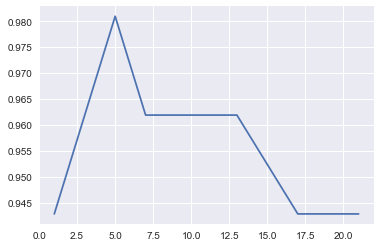

In [17]:
params = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
knn = KNeighborsClassifier()

grid_neighbors = GridSearchCV(knn, params, scoring='accuracy', cv=5)
grid_neighbors.fit(X_train, y_train)

# + alpha
# K가 작으면 train 데이터에 너무 overfitting되어 test 데이터의 score가 좋지 않다.
# K가 커질수록 underfitting되어 test 데이터의 score가 좋지 않다.
# -> 적절한 K의 중요성 !
sns.lineplot(x=grid_neighbors.cv_results_['param_n_neighbors'], y=grid_neighbors.cv_results_['mean_test_score'])

## 3. Evaluation

In [18]:
# 위에서 cv score가 가장 좋았던 original data + param 을 최종 model로 선택한다.
# (uniform과 distance가 동률이라서 distance를 선택하였다.)
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train) # training
pred = knn.predict(X_test) # predict

In [19]:
from sklearn.metrics import *
confusion_matrix(y_test, pred)
# 모든 test 데이터를 제대로 예측하였다.

array([[15,  0,  0],
       [ 0, 15,  0],
       [ 0,  0, 15]], dtype=int64)

In [20]:
print( accuracy_score(y_test, pred) )

1.0
